# Testing bias metrics and mitigation algorithms on a Synthetic dataset

The goal of this analysis is to make a comparison of different bias mitigation methods for classification problems on different types of dataset and to see how these methods impact on different fairness metrics and on the accuracy of the classifier. The datasets on which we will test the fairness algorithms are:

1. Unbias dataset
2. Bias unbalanced dataset
3. Bias balanced dataset

In [1]:
# import libraries
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utility import *
sns.set_theme()

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the target variable at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the target variable $y$ are changed s.t. the mean of the $y$ distribution is the mean between the mean of $y$ distribution for the privileged and unprivileged groups. 
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

## Dataset creation

Here we will create a binary labeled dataset with 10.000 samples and 11 features of which 4 are informative features and one will act as sensitive attribute:

In [2]:
n_samples = 10000
n_features = 10
n_informative = 4
n_sensitive = 2

In [3]:
data = pd.read_csv('synthetic/synthetic.csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,10,s
0,1.117819,2.978286,0.446270,1.462078,-0.603682,-1.010214,-0.850477,-0.534090,2.619979,2.847635,1.0,0
1,-1.241114,0.966580,2.522553,2.197615,-2.049246,-2.272453,-0.912986,-1.074081,0.156897,-0.893949,0.0,0
2,1.499456,3.462662,-1.581721,-0.717028,0.706507,0.067985,1.081010,-1.360287,2.342430,2.600052,1.0,1
3,1.119152,-1.030551,2.154243,-1.041053,0.374413,-1.707872,1.508272,0.426323,-1.545117,-1.741156,0.0,0
4,0.951065,3.900728,0.127303,-0.075893,0.416828,-1.444766,-0.093549,-2.440322,2.097760,1.317815,0.0,1


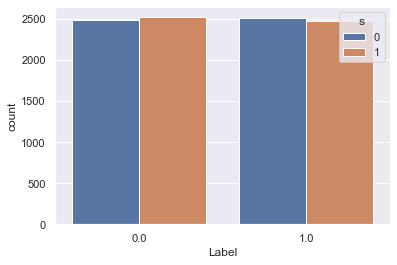

In [4]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

The dataset seems to be fair with respect to the sensitive attribute

In [5]:
unprivileged_group = [{'s': 0}]
privileged_group = [{'s': 1}]

# Unbias dataset

Here we will apply the metrics and the algorithms defined above on the unbias version of the dataset and compare how these bias mitigation algorithms change the different metrics.

## Dataset fairness metrics 

Let's compute the dataset fairness metrics defined above on the syntetic dataset to check that it is really unbias

In [6]:
bin_data = BinaryLabelDataset(df=data, label_names=['10'], protected_attribute_names=['s'])
metrics = compute_dataset_fairness_metrics(bin_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0161
Statistical Parity = 0.0080


The dataset is not bias.

## Classification bias metrics

Here we train and test a _Logistic Regression_ classifier:

Balanced accuracy: 0.7621
Statistical parity difference: 0.0159
Disparate impact: 1.0317
Average odds difference: 0.0119
Equal opportunity difference: 0.0138
Theil index: 0.1486


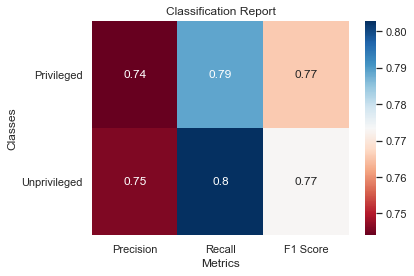

In [7]:
class_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    bin_data, privileged_group, unprivileged_group)

From the values of the metrics we can see that the classifier is fair and quite accurate. Let's now test the same metrics on a bias dataset.

## Reweighing

Here we apply the _Reweighing_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [8]:
rw_unbias_data = bin_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_unbias_data = rw.fit_transform(rw_unbias_data)

In [9]:
np.unique(rw_unbias_data.instance_weights)

array([0.99205719, 0.99206979, 1.00805802, 1.00807103])

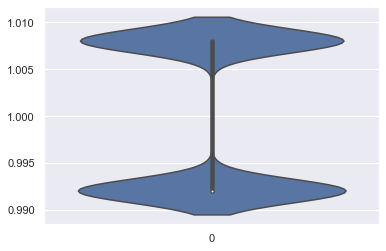

In [10]:
sns.violinplot(data=rw_unbias_data.instance_weights)
plt.show()

### Dataset metrics

In [11]:
metrics = compute_dataset_fairness_metrics(rw_unbias_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

Balanced accuracy: 0.7625
Statistical parity difference: 0.0052
Disparate impact: 1.0113
Average odds difference: 0.0054
Equal opportunity difference: 0.0078
Theil index: 0.1484


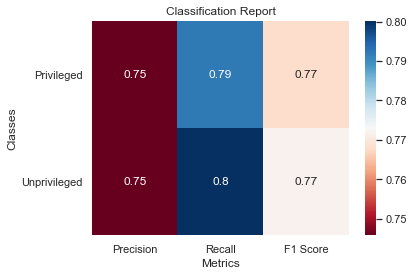

In [12]:
rw_un_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_unbias_data, privileged_group, unprivileged_group)

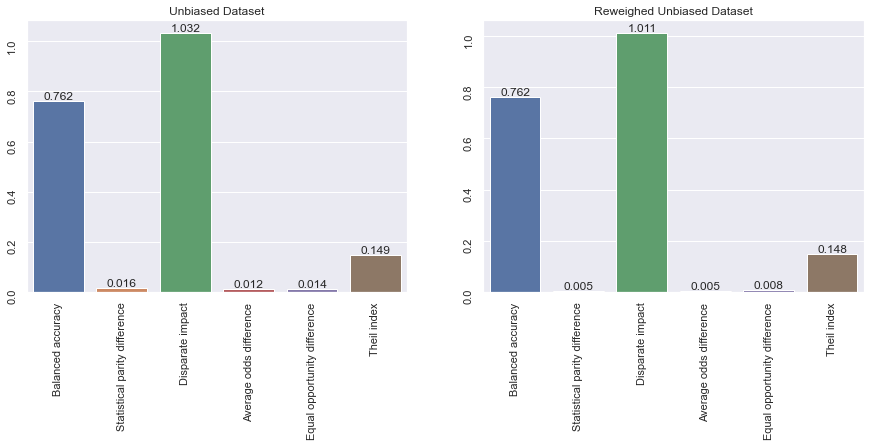

In [13]:
plot_metrics_comparison(class_metrics, rw_un_metrics, "Unbiased Dataset", "Reweighed Unbiased Dataset")
plt.show()

## Disparate Impact Remover

Here we apply the _Disparate Impact Remover_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [14]:
dir_unb_data = bin_data.copy()
scaler = MinMaxScaler(copy=False)
dir_unb_data.features = scaler.fit_transform(dir_unb_data.features)

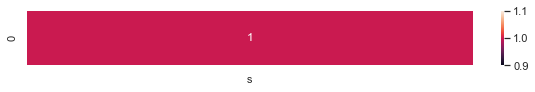

In [15]:
plot_correlation(dir_unb_data, 's')
plt.show()

In [16]:
di = DisparateImpactRemover(sensitive_attribute='s')
dir_unb_data = di.fit_transform(dir_unb_data)

### Dataset metrics

In [17]:
metrics = compute_dataset_fairness_metrics(dir_unb_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0161
Statistical Parity = 0.0080


### Classification metrics

Balanced accuracy: 0.7653
Statistical parity difference: 0.0061
Disparate impact: 1.0125
Average odds difference: 0.0021
Equal opportunity difference: 0.0051
Theil index: 0.1464


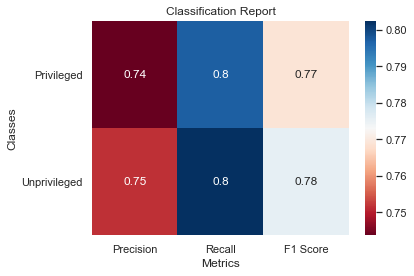

In [18]:
dir_fair_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_unb_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


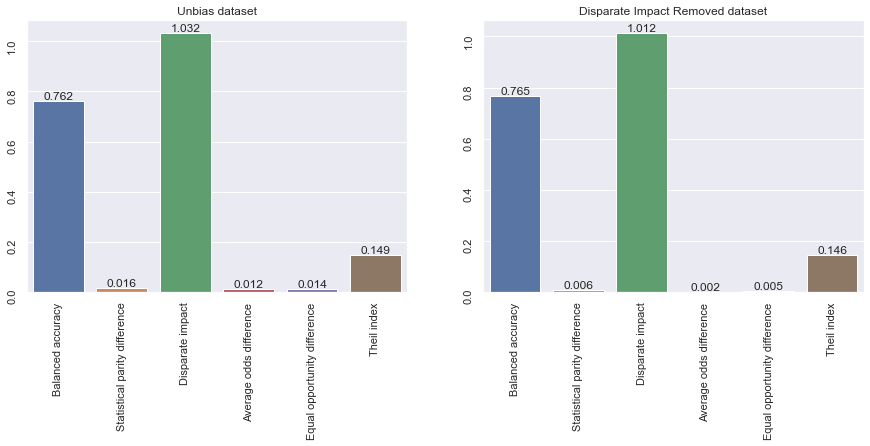

In [19]:
plot_metrics_comparison(class_metrics, dir_fair_metrics, "Unbias dataset", "Disparate Impact Removed dataset")
plt.show()

## Modified Reweighing (Sampling)

Original dataset size: (10000,12)
Sampled dataset size: (10000,12)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


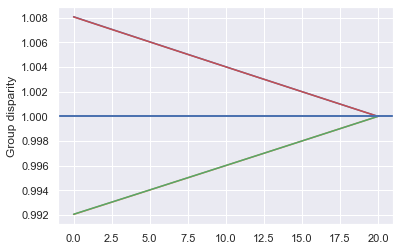

In [20]:
unb_sample_ds = data.copy()
unb_sample_ds = sample_dataset(
    unb_sample_ds,
    [unb_sample_ds['s']==1, unb_sample_ds['s']==0],
    unb_sample_ds['10']==1,
    unb_sample_ds['10']==0,
    ['s'], '10')
plt.show()

### Dataset Metrics

In [21]:
metrics = compute_dataset_fairness_metrics(unb_sample_ds, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification Metrics

Balanced accuracy: 0.7633
Statistical parity difference: 0.0020
Disparate impact: 1.0050
Average odds difference: 0.0022
Equal opportunity difference: 0.0019
Theil index: 0.1479


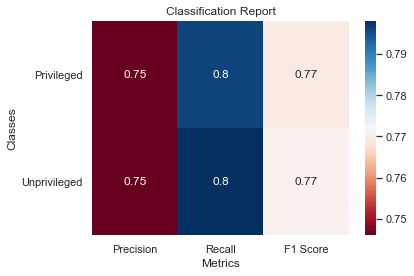

In [22]:
unb_sample_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  unb_sample_ds, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


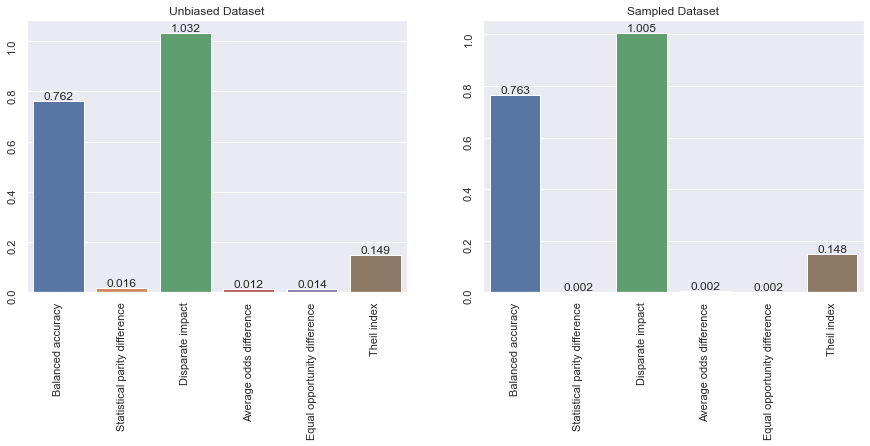

In [23]:
plot_metrics_comparison(class_metrics, unb_sample_metrics, 'Unbiased Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In the following we compare the performances of _Reweighing_ and _Disparate Impact Remover_ on the unbias dataset. 

In [24]:
un_merged_metrics = merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Sampled Dataset': unb_sample_metrics,
    'Disparate Impact Removed': dir_fair_metrics
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


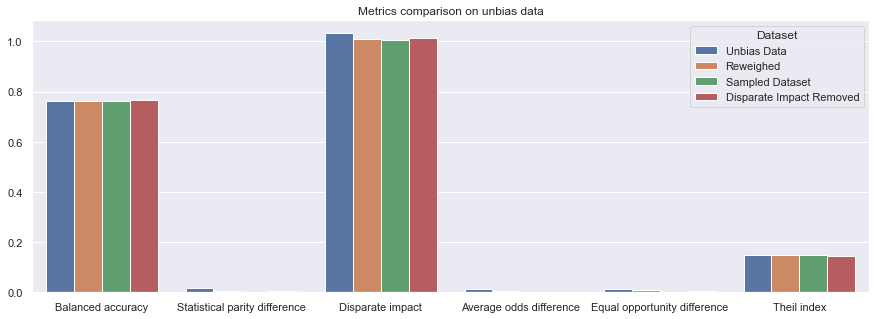

In [25]:
plot_syntesis(un_merged_metrics, 'Metrics comparison on unbias data')
plt.show()

# Unbalanced Bias dataset

Let's change the previous dataset adding a bias on the sensitive attribute `s` with value 0 and keeping the instances with `s=1` invariate:

In [26]:
bias_data = data.copy()
bias_data.loc[(bias_data['s'] == 0) & (bias_data.index < int(n_samples/2)) , '10'] = 0.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


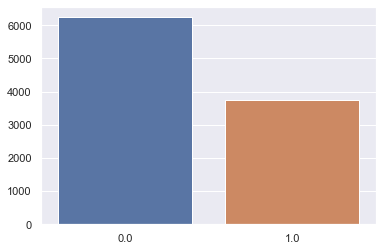

In [27]:
sns.barplot(x=bias_data['10'].value_counts().index, y=bias_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


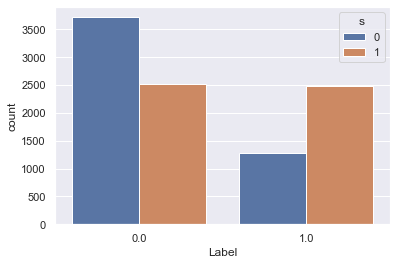

In [28]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

## Dataset fairness metrics

Let's compute the dataset fairness metrics on this new dataset:

In [29]:
bias_data_bin = BinaryLabelDataset(df = bias_data, label_names=['10'], protected_attribute_names=['s'])
bias_metrics = compute_dataset_fairness_metrics(bias_data_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.5174
Statistical Parity = -0.2392


## Classification bias metrics

Balanced accuracy: 0.7262
Statistical parity difference: -0.3985
Disparate impact: 0.3972
Average odds difference: -0.3548
Equal opportunity difference: -0.5183
Theil index: 0.1500


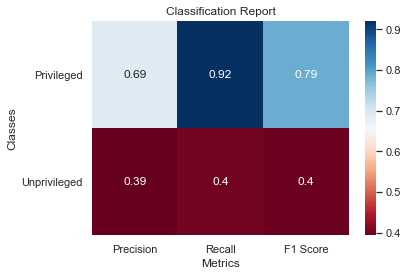

In [30]:
bias_class_metrics = classify(
    make_pipeline(StandardScaler(), 
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  bias_data_bin, privileged_group, unprivileged_group)

##  Reweighing

In [31]:
rw_data = bias_data_bin.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = rw.fit_transform(rw_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


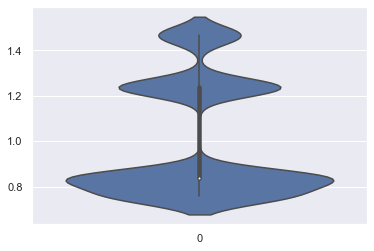

In [32]:
sns.violinplot(data=rw_data.instance_weights)
plt.show()

### Dataset metrics

In [33]:
rw_metrics = compute_dataset_fairness_metrics(rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


### Classification metrics

Balanced accuracy: 0.7117
Statistical parity difference: 0.0338
Disparate impact: 1.0746
Average odds difference: 0.0082
Equal opportunity difference: -0.0951
Theil index: 0.1434


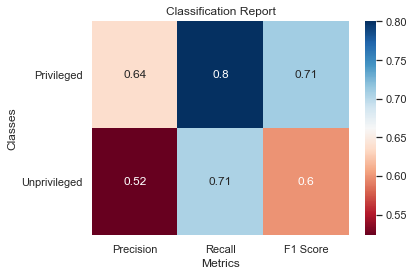

In [34]:
rw_class_metrics = classify(make_pipeline(StandardScaler(), 
                                          LogisticRegression(class_weight='balanced', solver='liblinear')), rw_data, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


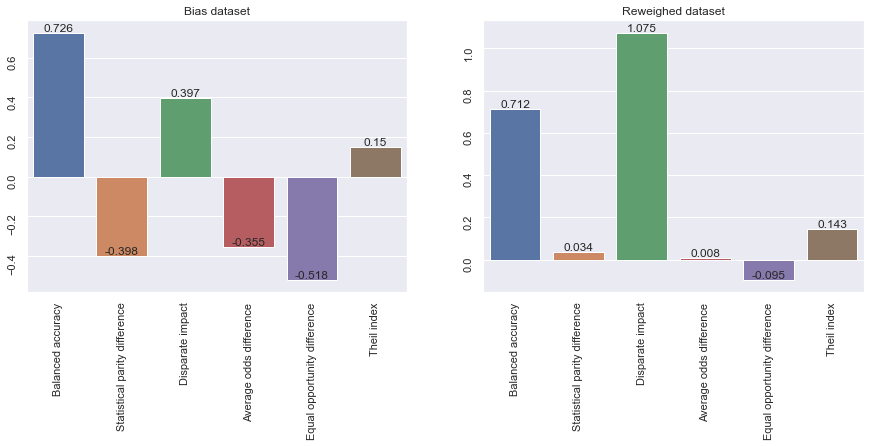

In [35]:
plot_metrics_comparison(bias_class_metrics, rw_class_metrics, "Bias dataset", "Reweighed dataset")
plt.show()

## Disparate Impact Remover

In [36]:
dir_data = bias_data_bin.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


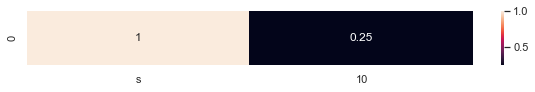

In [37]:
plot_correlation(dir_data, 's')
plt.show()

In [38]:
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_data = dr.fit_transform(dir_data)

### Dataset metrics

In [39]:
dir_metrics = compute_dataset_fairness_metrics(dir_data, unprivileged_group, privileged_group)

Disparate Impact = 0.5174
Statistical Parity = -0.2392


### Classification metrics

Balanced accuracy: 0.7060
Statistical parity difference: 0.0070
Disparate impact: 1.0157
Average odds difference: 0.0901
Equal opportunity difference: 0.0113
Theil index: 0.1498


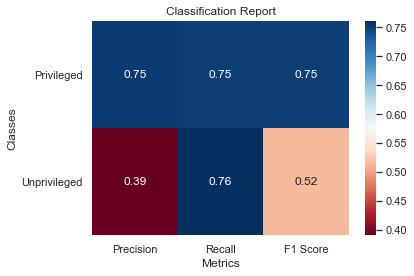

In [40]:
dir_class_metrics = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced',solver='liblinear')), dir_data, privileged_group, unprivileged_group,sensitive_attributes=['s'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


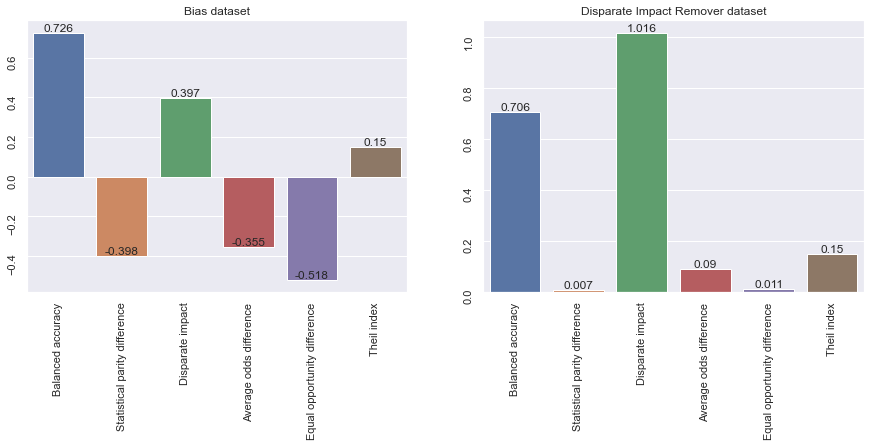

In [41]:
plot_metrics_comparison(bias_class_metrics, dir_class_metrics, "Bias dataset", "Disparate Impact Remover dataset")
plt.show()

## Modified Reweighing (Sampling)

Original dataset size: (10000,12)
Sampled dataset size: (10000,12)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


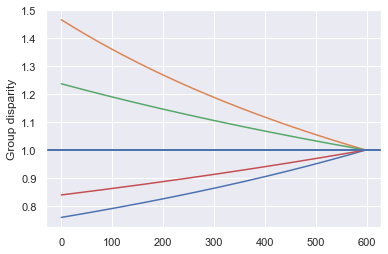

In [42]:
sample_bias_data = sample_dataset(bias_data.copy(),
 [(bias_data['s']==1), (bias_data['s']==0)], 
 bias_data['10']==1, bias_data['10']==0, ['s'], '10')
plt.show()

In [43]:
metrics = compute_dataset_fairness_metrics(sample_bias_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7111
Statistical parity difference: 0.0357
Disparate impact: 1.0780
Average odds difference: 0.0119
Equal opportunity difference: -0.0851
Theil index: 0.1488


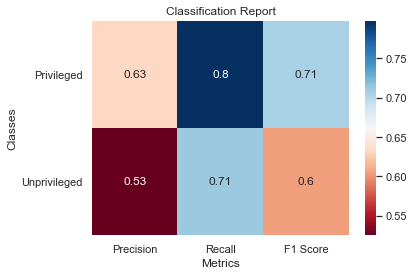

In [44]:
sample_bias_metrics = classify(make_pipeline(StandardScaler(), 
                                             LogisticRegression(class_weight='balanced', solver='liblinear')), 
                               sample_bias_data, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


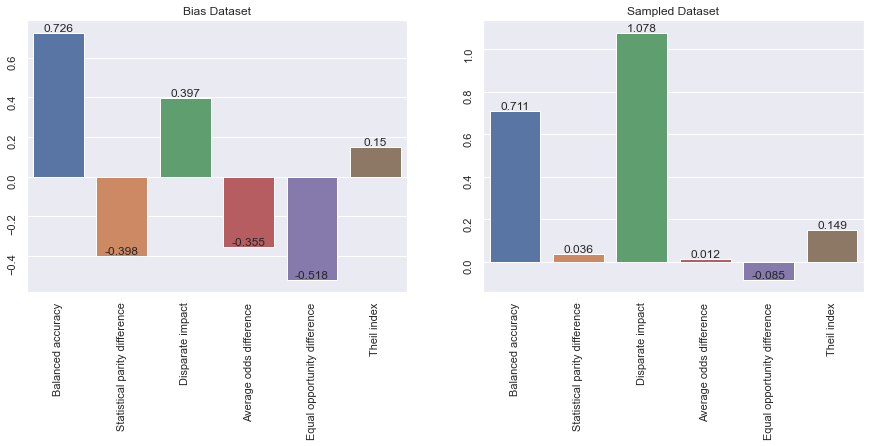

In [45]:
plot_metrics_comparison(bias_class_metrics, sample_bias_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [46]:
unbal_merged_metrics = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Sampled Dataset': sample_bias_metrics,
    'Disparate Impact Removed': dir_class_metrics
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


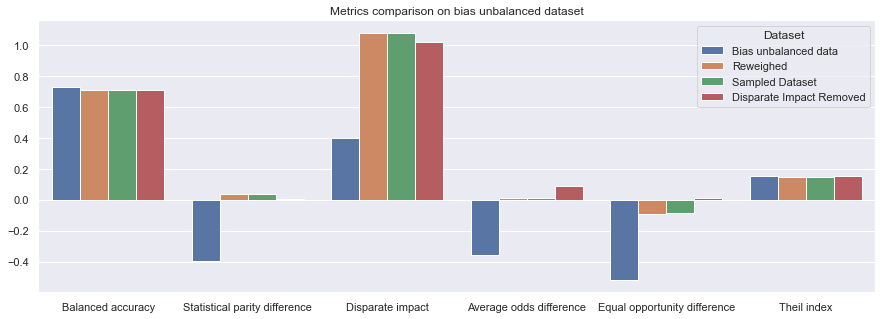

In [47]:
plot_syntesis(unbal_merged_metrics, 'Metrics comparison on bias unbalanced dataset')
plt.show()

# Bias balanced dataset

Let's balance the previous dataset changing the labels of half of the samples with `s=1` to `1.0`

In [48]:
bias_bal_data = bias_data.copy()
bias_bal_data.loc[(bias_data['s'] == 1) & (bias_data.index < int(n_samples/2)) & (bias_data['10']==0.0) , '10'] = 1.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


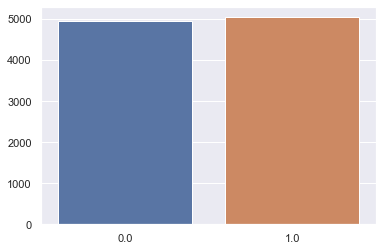

In [49]:
sns.barplot(x=bias_bal_data['10'].value_counts().index, y=bias_bal_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


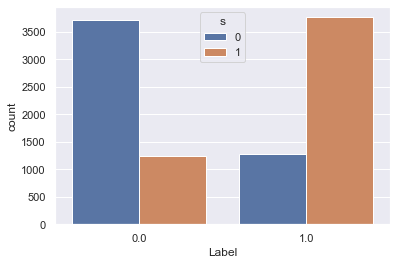

In [50]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_bal_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

In [51]:
bias_bal_bin = BinaryLabelDataset(df=bias_bal_data, label_names=['10'], protected_attribute_names=['s'])

## Dataset metrics

In [52]:
bal_metrics = compute_dataset_fairness_metrics(bias_bal_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.3406
Statistical Parity = -0.4964


## Classification metrics

Balanced accuracy: 0.7422
Statistical parity difference: -0.8863
Disparate impact: 0.0420
Average odds difference: -0.8570
Equal opportunity difference: -0.8918
Theil index: 0.1899


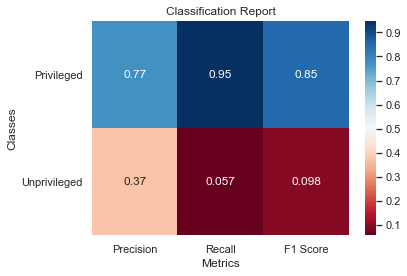

In [53]:
bias_bal_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    bias_bal_bin, privileged_group, unprivileged_group)

## Reweighing

In [54]:
rw_bal = bias_bal_bin.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_bal = rw.fit_transform(rw_bal)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


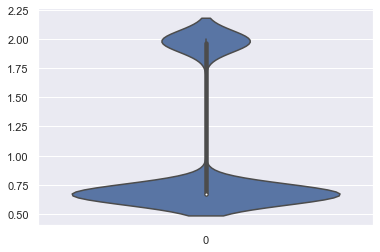

In [55]:
sns.violinplot(data=rw_bal.instance_weights)
plt.show()

### Dataset metrics

In [56]:
rw_metrics = compute_dataset_fairness_metrics(rw_bal, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

Balanced accuracy: 0.6687
Statistical parity difference: 0.0286
Disparate impact: 1.0555
Average odds difference: 0.0303
Equal opportunity difference: 0.0237
Theil index: 0.2144


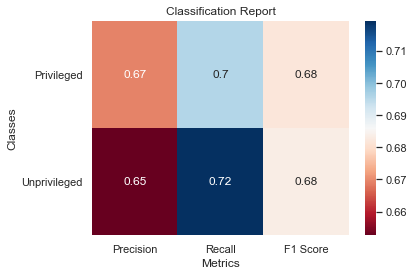

In [57]:
rw_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_bal, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


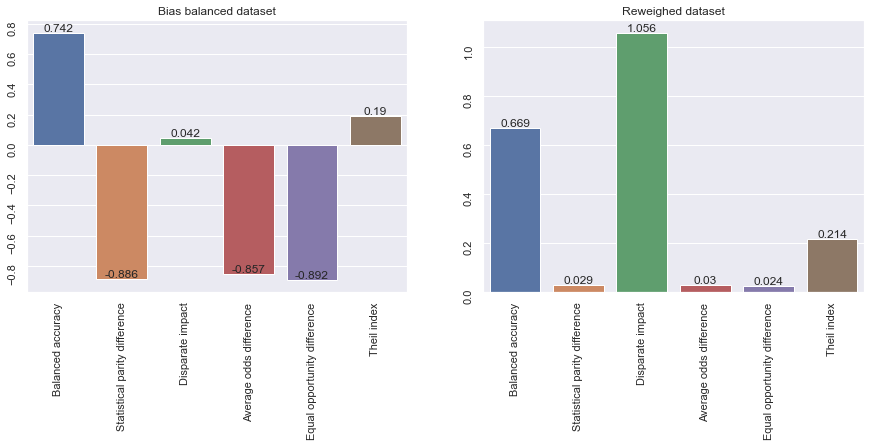

In [58]:
plot_metrics_comparison(bias_bal_metrics, rw_metrics, 'Bias balanced dataset', 'Reweighed dataset')
plt.show()

## Modified Reweighing (Sampling)

Original dataset size: (10000,12)
Sampled dataset size: (10000,12)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


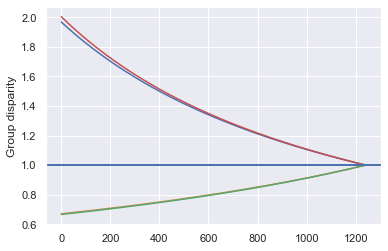

In [59]:
bias_sample_ds = sample_dataset(
    bias_bal_data.copy(),
    [bias_bal_data['s']==0, bias_bal_data['s']==1],
    bias_bal_data['10']==1,
    bias_bal_data['10']==0,
    ['s'], '10')
plt.show()

In [60]:
metrics = compute_dataset_fairness_metrics(bias_sample_ds,unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.6686
Statistical parity difference: 0.0399
Disparate impact: 1.0793
Average odds difference: 0.0401
Equal opportunity difference: 0.0393
Theil index: 0.2105


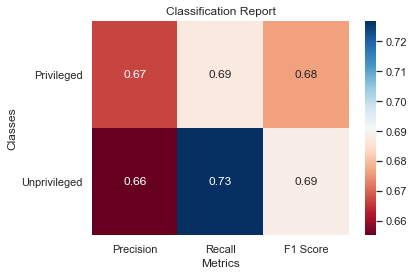

In [61]:
sampling_metrics = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                            bias_sample_ds, privileged_group, unprivileged_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


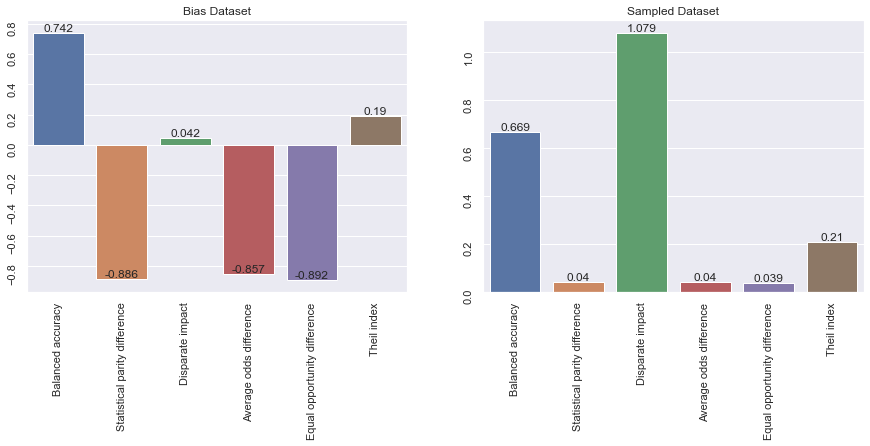

In [62]:
plot_metrics_comparison(bias_bal_metrics, sampling_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Disparate Impact Remover

In [63]:
dir_bal = bias_bal_bin.copy()
scaler = MinMaxScaler()
dir_bal.features = scaler.fit_transform(dir_bal.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


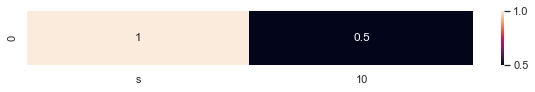

In [64]:
plot_correlation(dir_bal, 's')
plt.show()

In [65]:
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_bal = dr.fit_transform(dir_bal)

### Dataset metrics

In [66]:
dir_metrics = compute_dataset_fairness_metrics(dir_bal, unprivileged_group, privileged_group)

Disparate Impact = 0.3406
Statistical Parity = -0.4964


### Classification metrics

Balanced accuracy: 0.6293
Statistical parity difference: 0.0085
Disparate impact: 1.0178
Average odds difference: 0.1815
Equal opportunity difference: 0.1873
Theil index: 0.2328


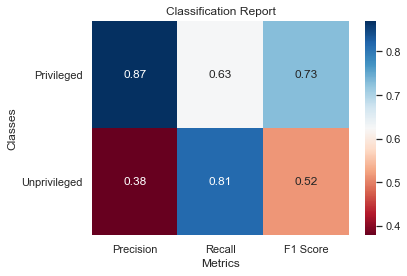

In [67]:
dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                     dir_bal, privileged_group, unprivileged_group, sensitive_attributes=['s'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


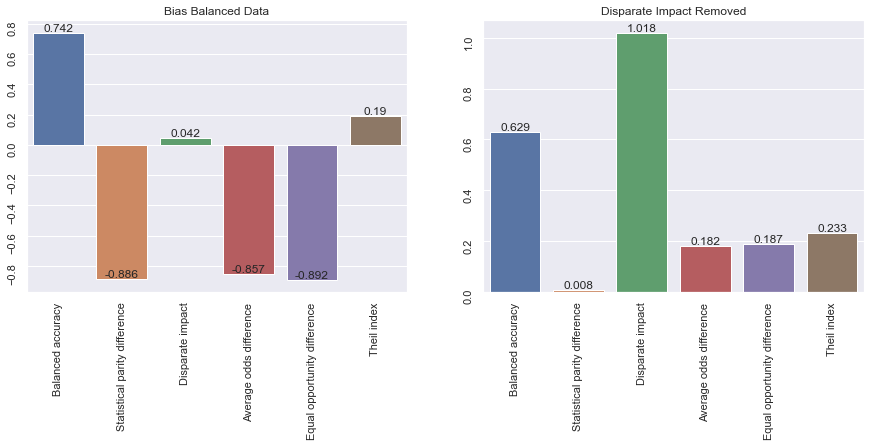

In [68]:
plot_metrics_comparison(bias_bal_metrics, dir_score, 'Bias Balanced Data', 'Disparate Impact Removed')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [69]:
bal_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Sampled Dataset': sampling_metrics,
    'Disparate Impact Removed': dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


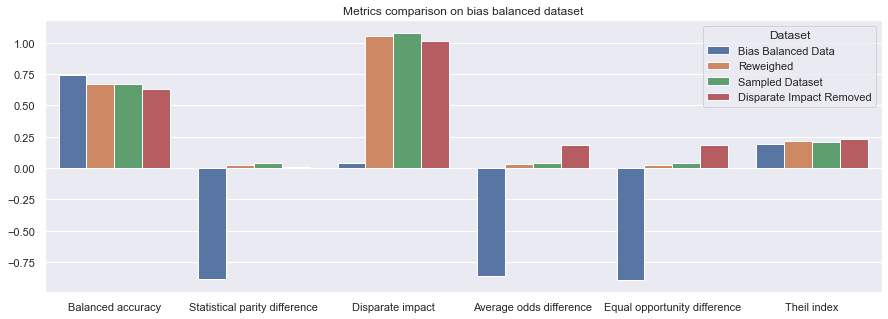

In [70]:
plot_syntesis(bal_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()

# Comparison of the three datasets

Here we compare the metrics for the three versions of the dataset and the methods applied:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


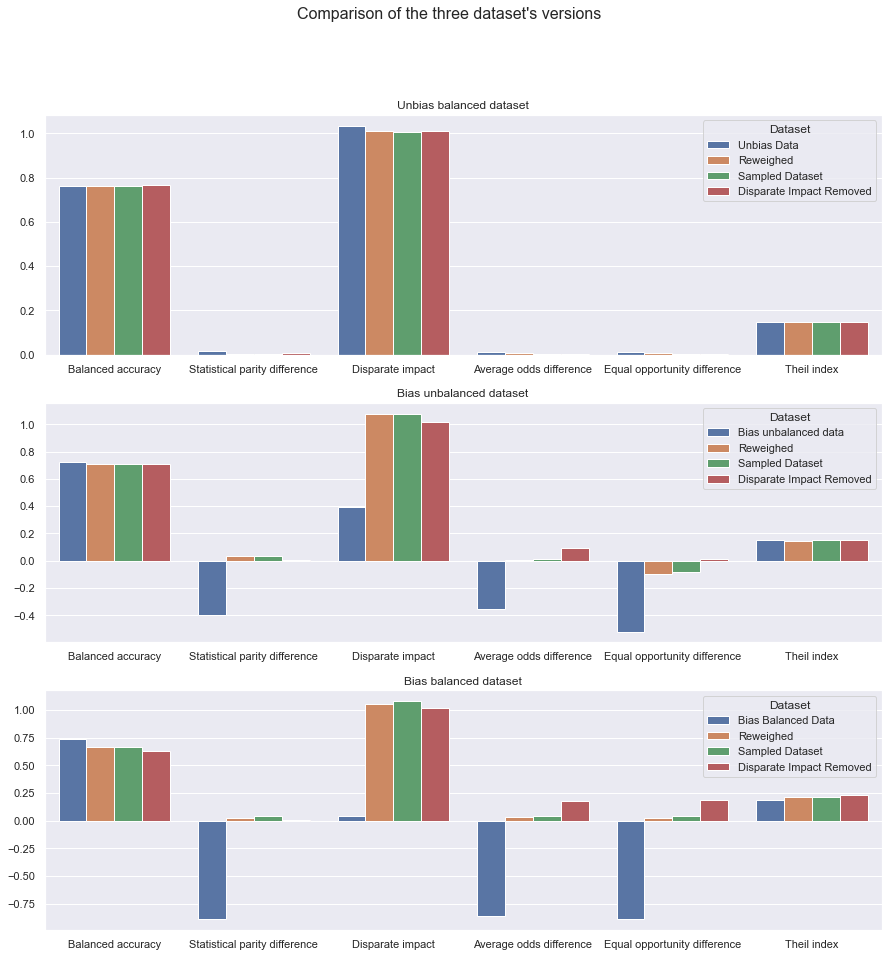

In [71]:
fig, axes = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=un_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[0],)
sns.barplot(data=unbal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[1])
sns.barplot(data=bal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[2])
for ax in axes:
    ax.set(xlabel='', ylabel='')
axes[0].set_title('Unbias balanced dataset')
axes[1].set_title('Bias unbalanced dataset')
axes[2].set_title('Bias balanced dataset')
fig.suptitle("Comparison of the three dataset's versions", fontsize=16)
plt.show()

# Combine Reweighing and DIR

As can be seen from the charts above both RW and DIR performs well in mitigating the unfairness of the classifier. However both have some lacks:

1. Reweighing requires that a classifier takes account of instance weights, but not all the classifier models do so
2. Disparate Impact Remover has no effect on the dataset fairness metrics but only on the classifier metrics

To solve these problems we will now try to combine these two algorithms by applying the instance weights to the DIR modified dataset and see the results.

## Test with unbias data

In [72]:
un_rw_dir = dir_unb_data.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
un_rw_dir = rw.fit_transform(un_rw_dir)

In [73]:
score = compute_dataset_fairness_metrics(un_rw_dir, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7657
Statistical parity difference: 0.0030
Disparate impact: 1.0071
Average odds difference: 0.0033
Equal opportunity difference: 0.0038
Theil index: 0.1460


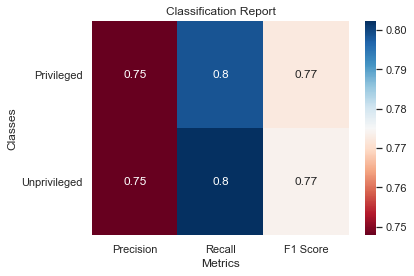

In [74]:
unb_rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            un_rw_dir, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [75]:
un_rw_dir_merg =  merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics,
    'RW + DIR': unb_rw_dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


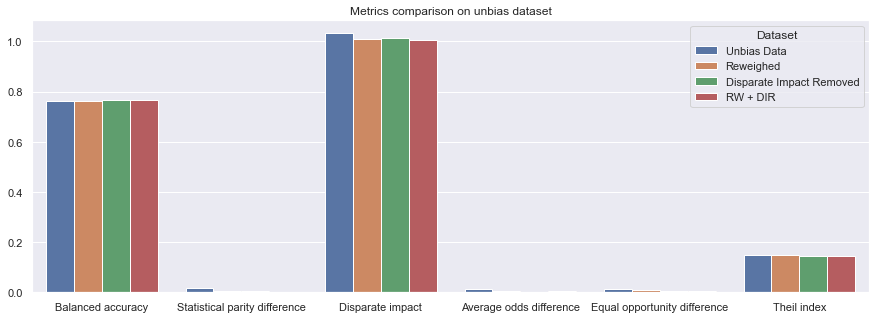

In [76]:
plot_syntesis(un_rw_dir_merg, 'Metrics comparison on unbias dataset')
plt.show()

## Test with unbalance bias data

In [77]:
unbal_dir_rw_data = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
unbal_dir_rw_data = rw.fit_transform(unbal_dir_rw_data)

In [78]:
score = compute_dataset_fairness_metrics(unbal_dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


Balanced accuracy: 0.7145
Statistical parity difference: 0.1095
Disparate impact: 1.2525
Average odds difference: 0.0904
Equal opportunity difference: 0.0112
Theil index: 0.1479


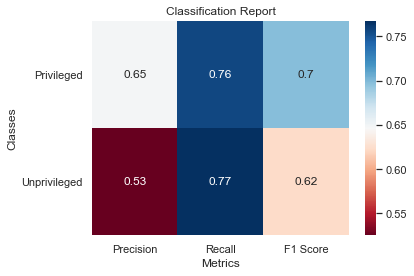

In [79]:
rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            unbal_dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [80]:
unbal_rw_dir_score = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics,
    'RW + DIR': rw_dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


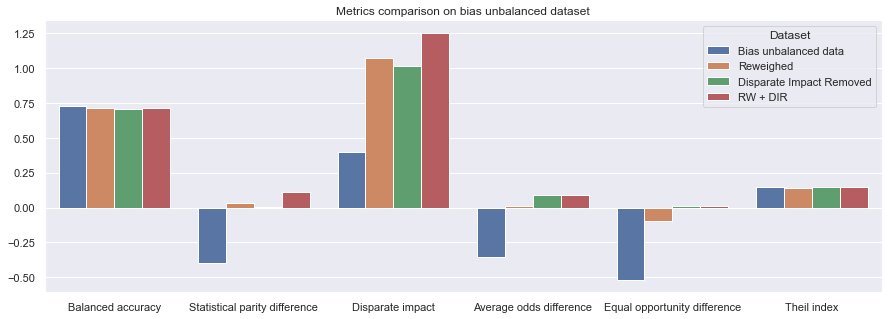

In [81]:
plot_syntesis(unbal_rw_dir_score, 'Metrics comparison on bias unbalanced dataset')
plt.show()

## Test with balanced bias data

In [82]:
dir_rw_data = dir_bal.copy()
rw = Reweighing(unprivileged_group, privileged_group)
dir_rw_data = rw.fit_transform(dir_rw_data)

In [83]:
score = compute_dataset_fairness_metrics(dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.6761
Statistical parity difference: 0.1817
Disparate impact: 1.4099
Average odds difference: 0.1823
Equal opportunity difference: 0.1868
Theil index: 0.2350


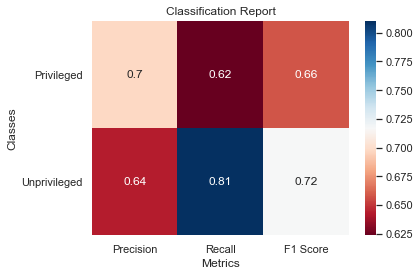

In [84]:
rw_dir_score = classify(make_pipeline(StandardScaler(),LogisticRegression(class_weight='balanced', solver='liblinear')),
                        dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [85]:
rw_dir_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score,
    'RW + DIR': rw_dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


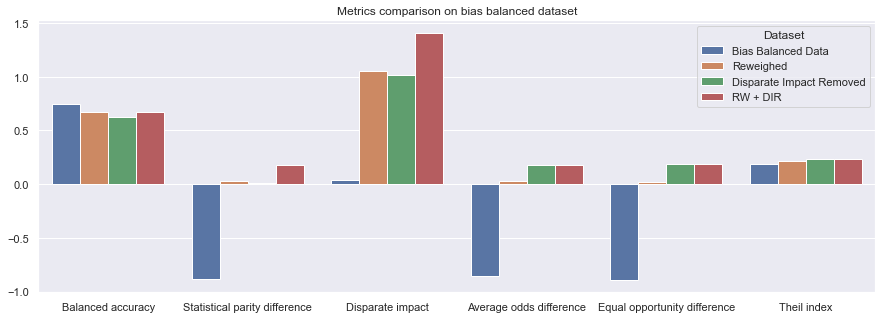

In [86]:
plot_syntesis(rw_dir_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()